In [1]:
from src.dataset.shelf import Shelf
from src.box_clustering import multiViewHumanBoxesClustering
from src.multiview_3d import solveMultiView3DHumanPoses
from src.bundle_adjustment import bundleAdjustmentWrapper
from src.plot_functions import *
from src.evaluate import *
import yaml

data_dir = '../_WildTrack/data/shelf'
config = yaml.safe_load(open('./config/panoptic.yml', 'r'))
dataset = Shelf(data_dir, config=config)
frame_id = 576
wrld_cam_id = 0


# --- Step 1: crop bounding box
boxcrop_dir = dataset.getSingleFrameMultiViewBoxes(frame_id)
box_reid_feat = dataset.getFrameReIDFeat(frame_id)

# # --- Step 2: cluster boxes using re-ID feature
boxfile_clusters = multiViewHumanBoxesClustering(
    box_reid_feat, size_max=dataset.num_cam,
    method='kmeans_ssc')

print(boxfile_clusters)

# --- Step 3: generate 2D-2D point correpondences
pts_corresp_dict, n_persons = dataset.genPtsCorrepFromBoxClus(
    boxfile_clusters)

# # --- Step 4: solve 3D human pose
Pts, BA_input, wrld_cam_name = solveMultiView3DHumanPoses(
    pts_corresp_dict, dataset.cam_params_dict, n_persons,
    Pts_prev=None, wrld_cam_id=wrld_cam_id)

# --- Step 5: bundle adjustement
Pts_BA, M2s_BA = bundleAdjustmentWrapper(
    BA_input, fix_cam_pose=False, wrld_cam_id=wrld_cam_id)


Perform clustering:
[0.02 seconds] "kmeans_ssc" | "cosine" | 3 clusters.

Method         Distance       Purity    RI        ARI       F_Score   
kmeans_ssc     cosine         1.000     1.000     1.000     1.000     

{0: ['./data/shelf/box_crop/frame00000576/Camera0_0_89_232_763_409.jpg', './data/shelf/box_crop/frame00000576/Camera1_0_146_490_654_676.jpg', './data/shelf/box_crop/frame00000576/Camera2_0_129_575_595_704.jpg', './data/shelf/box_crop/frame00000576/Camera3_0_94_529_601_637.jpg', './data/shelf/box_crop/frame00000576/Camera4_0_38_553_515_742.jpg'], 2: ['./data/shelf/box_crop/frame00000576/Camera0_2_148_826_692_986.jpg', './data/shelf/box_crop/frame00000576/Camera1_2_213_709_547_830.jpg', './data/shelf/box_crop/frame00000576/Camera2_2_0_423_313_534.jpg', './data/shelf/box_crop/frame00000576/Camera3_2_140_78_557_168.jpg', './data/shelf/box_crop/frame00000576/Camera4_2_50_88_761_280.jpg'], 1: ['./data/shelf/box_crop/frame00000576/Camera1_1_163_418_595_488.jpg', './data/shelf/bo

Plot joints in shelf | camera Camera0 | frame 576.
Plot joints in shelf | camera Camera1 | frame 576.
Plot joints in shelf | camera Camera2 | frame 576.
Plot joints in shelf | camera Camera3 | frame 576.
Plot joints in shelf | camera Camera4 | frame 576.


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

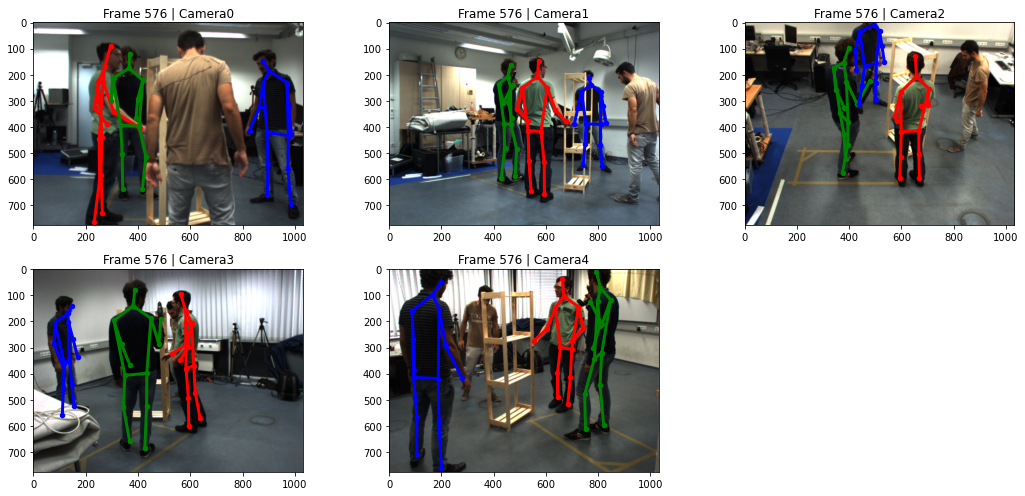

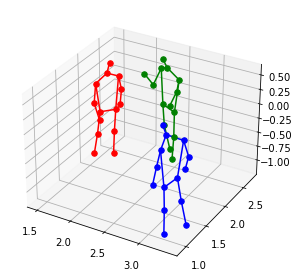

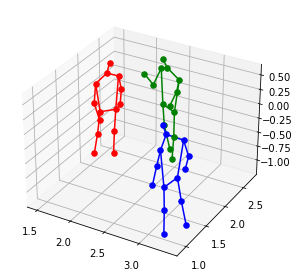

In [2]:
# --- Visualize 2D pose
plotSingleFrameMultiView2dJoints(
    dataset, frame_id, plot_joint_id=False, save_plot=True)

rot_x = 0
rot_z = 180
xlim, ylim, zlim = None, None, None

Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
_, Pts_world, _, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
# Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

Pts_w_gt, Pts_w_est, _, scale = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)
# Pts_w_est = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_w_est.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_w_est, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)